In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from large_image import getTileSource
import numpy as np
import json

In [7]:
annotations = gpd.read_file('./expanded_bboxes.geojson')
annotations["classification"] = annotations["classification"].apply(json.loads)

In [8]:
# load the WSI
wsi_path = "./data/slide-2024-04-03T07-52-35-R1-S2.mrxs"
source = getTileSource(wsi_path)

metadata = source.getMetadata()
mpp_x = float(metadata.get("mm_x", 0)) * 1000  # convert mm to microns
mpp_y = float(metadata.get("mm_y", 0)) * 1000

print(f"WSI Resolution: {mpp_x} × {mpp_y} microns per pixel")

WSI Resolution: 0.274358240290104 × 0.274358240290104 microns per pixel


In [5]:

def plot_annotation(annotation, ax=None):
    roi_polygon = annotation.geometry
    minx, miny, maxx, maxy = roi_polygon.bounds

    margin = 100
    x0, y0 = int(minx - margin), int(miny - margin)
    x1, y1 = int(maxx + margin), int(maxy + margin)
    width, height = x1 - x0, y1 - y0

    region = {
        'left': int(x0),
        'top': int(y0),
        'width': int(width),
        'height': int(height),
        'units': 'base_pixels'
    }

    tile_image, _ = source.getRegion(region=region, format='PIL')
    tile_rgb = np.array(tile_image.convert("RGB"))

    # If ax not provided, create a new figure/axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.imshow(tile_rgb, extent=[x0, x1, y1, y0])

    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)
    ax.set_title(annotation.classification["name"])
    ax.axis("off")


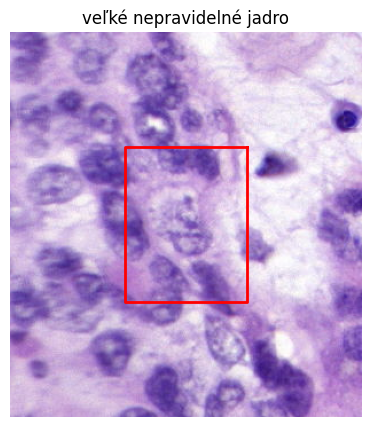

In [9]:
plot_annotation(annotations.iloc[0])

In [19]:
def get_annotation_rgb_tile(annotaition):
    roi_polygon = annotaition.geometry
    minx, miny, maxx, maxy = roi_polygon.bounds

    margin = 100
    x0, y0 = int(minx - margin), int(miny - margin)
    x1, y1 = int(maxx + margin), int(maxy + margin)
    width, height = x1 - x0, y1 - y0

    region = {
        'left': int(x0),
        'top': int(y0),
        'width': int(width),
        'height': int(height),
        'units': 'base_pixels'
    }

    tile_image, _ = source.getRegion(region=region, format='PIL')
    tile_rgb = np.array(tile_image.convert("RGB"))

    return tile_rgb

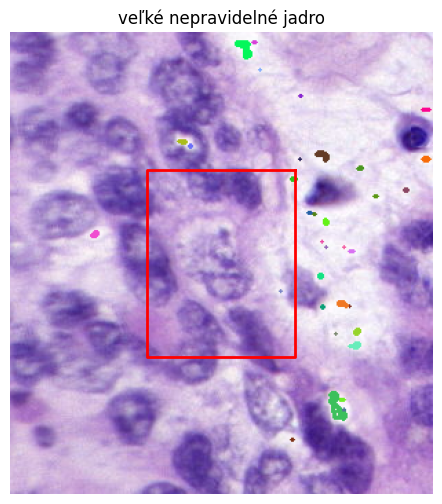

In [76]:
import cv2

def process_annotation(annotation, rgb_tile=None, ax=None):
    roi_polygon = annotation.geometry
    minx, miny, maxx, maxy = roi_polygon.bounds

    margin = 100
    x0, y0 = int(minx - margin), int(miny - margin)
    x1, y1 = int(maxx + margin), int(maxy + margin)
    width, height = x1 - x0, y1 - y0

    region = {
        'left': int(x0),
        'top': int(y0),
        'width': int(width),
        'height': int(height),
        'units': 'base_pixels'
    }

    tile_rgb = rgb_tile
    if tile_rgb is None:
        tile_image, _ = source.getRegion(region=region, format='PIL')
        tile_rgb = np.array(tile_image.convert("RGB"))

    # Convert to grayscale
    gray = cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2GRAY)

    # Threshold (you can adjust depending on tissue/background contrast)
    # _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY cv2.THRESH_OTSU)

    hsv = cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, thresh = cv2.threshold(h, 50, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a copy
    contour_img = tile_rgb.copy()
    # color = (0, 255, 0) # -> green contours
    # cv2.drawContours(contour_img, contours, -1, color, 2)
    for cnt in contours:
        color = tuple(np.random.randint(0, 256, size=3).tolist())  # random BGR
        cv2.drawContours(contour_img, [cnt], -1, color, 2)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Show original with contours
    ax.imshow(contour_img, extent=[x0, x1, y1, y0])
    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)  # your annotation outline
    ax.set_title(annotation.classification["name"])
    ax.axis("off")

process_annotation(annotations.iloc[0])


In [ ]:
def separate_h_and_e(rgb_tile=None):
    """
    This code normalizes staining appearance of H&E stained images.
    It also separates the hematoxylin and eosing stains in to different images. 

    Workflow based on the following papers:
    A method for normalizing histology slides for quantitative analysis. 
    M. Macenko et al., ISBI 2009
        http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf

    Efficient nucleus detector in histopathology images. J.P. Vink et al., J Microscopy, 2013

    Original MATLAB code:
        https://github.com/mitkovetta/staining-normalization/blob/master/normalizeStaining.m
    
    Other useful references:
        https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5226799/
        https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169875

    PROPOSED WORKFLOW:  
        
    Input: RGB image
    Step 1: Convert RGB to OD
    Step 2: Remove data with OD intensity less than β
    Step 3: Calculate  singular value decomposition (SVD) on the OD tuples
    Step 4: Create plane from the SVD directions corresponding to the
    two largest singular values
    Step 5: Project data onto the plane, and normalize to unit length
    Step 6: Calculate angle of each point wrt the first SVD direction
    Step 7: Find robust extremes (αth and (100−α)th 7 percentiles) of the
    angle
    Step 8: Convert extreme values back to OD space

    Output: Optimal Stain Vectors

    """

    import numpy as np
    import cv2
    from matplotlib import pyplot as plt

    ############### INPUT RGB IMAGE #######################
    #Using opencv to read images may bemore robust compared to using skimage
    #but need to remember to convert BGR to RGB.
    #Also, convert to float later on and normalize to between 0 and 1.

    #Image downloaded from:
    #https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
    img = rgb_tile
    if img is None:
        img = get_annotation_rgb_tile(annotations.iloc[0])

    Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
    alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
    beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                    [0.7201, 0.8012],
                    [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])


    # extract the height, width and num of channels of image
    h, w, c = img.shape

    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))

    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 

    OD = -np.log10((img.astype(np.float32)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)

    """
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(img[:,0],img[:,1],img[:,2])
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(OD[:,0],OD[:,1],OD[:,2])

    plt.show()
    """

    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()

    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product

    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)

    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T


    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]

    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])

    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 

    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

    # Separating H and E components

    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

    # plt.imshow(Inorm)
    # plt.imshow(H)
    # plt.imshow(E)
    return Inorm, H, E


In [172]:
original_annotations = gpd.read_file('./data/slide-2024-04-03T07-52-35-R1-S2.geojson')

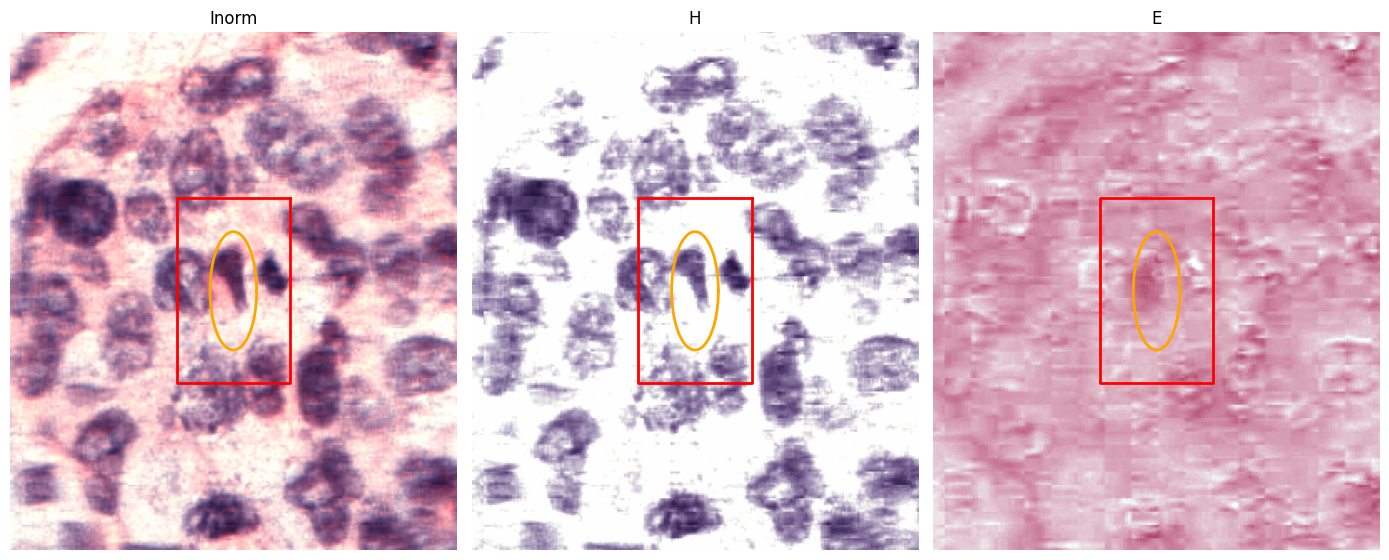

In [198]:
ANNOTATION_IDX = 10
example_annotation = annotations.iloc[ANNOTATION_IDX]
original_annotation = original_annotations.iloc[ANNOTATION_IDX]

Inorm, H, E = separate_h_and_e(get_annotation_rgb_tile(example_annotation))

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
for ax, component, title in zip(axes, [Inorm, H, E], ['Inorm', 'H', 'E']):
    roi_polygon = example_annotation.geometry
    minx, miny, maxx, maxy = roi_polygon.bounds

    margin = 100
    x0, y0 = int(minx - margin), int(miny - margin)
    x1, y1 = int(maxx + margin), int(maxy + margin)


    ax.imshow(component, extent=[x0, x1, y1, y0])

    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)

    x, y = original_annotation.geometry.exterior.xy
    ax.plot(x, y, color='orange', linewidth=2)

    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

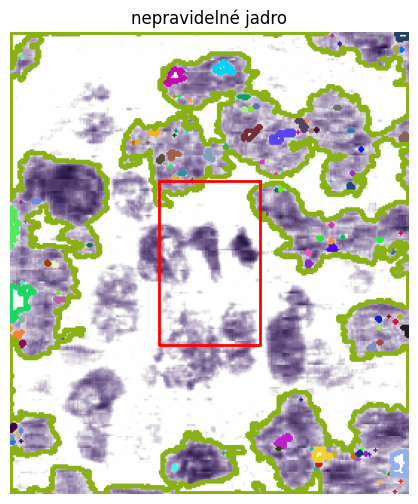

In [199]:
process_annotation(example_annotation, rgb_tile=H)

In [200]:
def process_annotation_ellipse(annotation, rgb_tile=None, ax=None):
    roi_polygon = annotation.geometry
    minx, miny, maxx, maxy = roi_polygon.bounds

    margin = 100
    x0, y0 = int(minx - margin), int(miny - margin)
    x1, y1 = int(maxx + margin), int(maxy + margin)
    width, height = x1 - x0, y1 - y0

    region = {
        'left': int(x0),
        'top': int(y0),
        'width': int(width),
        'height': int(height),
        'units': 'base_pixels'
    }

    tile_rgb = rgb_tile
    if tile_rgb is None:
        tile_image, _ = source.getRegion(region=region, format='PIL')
        tile_rgb = np.array(tile_image.convert("RGB"))

    # Convert to grayscale
    gray = cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2GRAY)

    # Preprocess: blur + threshold (or your HSV method)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ellipse_img = tile_rgb.copy()

    for cnt in contours:
        if len(cnt) < 5:
            continue  # need at least 5 points

        area = cv2.contourArea(cnt)
        if area < 20 or area > 5000:
            continue  # filter small noise or huge regions

        ellipse = cv2.fitEllipse(cnt)
        cv2.ellipse(ellipse_img, ellipse, (0, 255, 0), 2)  # draw green ellipse

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(ellipse_img, extent=[x0, x1, y1, y0])
    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)
    ax.set_title(annotation.classification["name"])
    ax.axis("off")


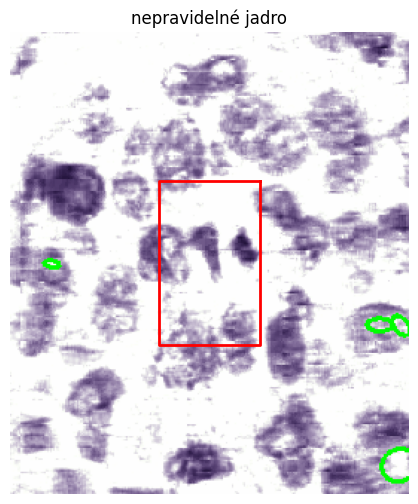

In [201]:
process_annotation_ellipse(example_annotation, rgb_tile=H)

In [202]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_annotation_ellipse_watershed(annotation, rgb_tile=None, ax=None, original_annotation=None):
    roi_polygon = annotation.geometry
    minx, miny, maxx, maxy = roi_polygon.bounds

    margin = 100
    x0, y0 = int(minx - margin), int(miny - margin)
    x1, y1 = int(maxx + margin), int(maxy + margin)
    width, height = x1 - x0, y1 - y0

    region = {
        'left': int(x0),
        'top': int(y0),
        'width': int(width),
        'height': int(height),
        'units': 'base_pixels'
    }

    tile_rgb = rgb_tile
    if tile_rgb is None:
        tile_image, _ = source.getRegion(region=region, format='PIL')
        tile_rgb = np.array(tile_image.convert("RGB"))

    # Convert to grayscale
    gray = cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2GRAY)
    
    # Adaptive thresholding
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(
        src=blur,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=21,
        C=2
    )

    # Morphological operations to clean small noise
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Distance transform
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.1*dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(thresh, sure_fg)

    # Marker labeling for watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(tile_rgb, markers)
    ellipse_img = tile_rgb.copy()

    # Extract ellipses from watershed regions
    for marker_id in np.unique(markers):
        if marker_id <= 1:  # skip background and boundary
            continue
        mask = np.uint8(markers == marker_id)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if len(cnt) < 5:
                continue
            area = cv2.contourArea(cnt)
            if area < 20 or area > 5000:
                continue
            ellipse = cv2.fitEllipse(cnt)
            cv2.ellipse(ellipse_img, ellipse, (0, 255, 0), 2)

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(ellipse_img, extent=[x0, x1, y1, y0])
    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)
    if original_annotation is not None:
        x, y = original_annotation.geometry.exterior.xy
        ax.plot(x, y, color='orange', linewidth=2)
    ax.set_title(annotation.classification["name"])
    ax.axis("off")


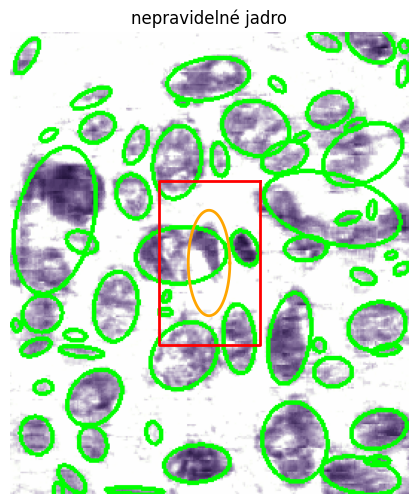

In [203]:
process_annotation_ellipse_watershed(example_annotation, original_annotation=original_annotation, rgb_tile=H)